# Convolutional Neural Network -- Labeled Faces in the Wild Database

## Team 1: Shou-An Cheng, Jiaqi Fan, Chen Liu, Dan Liu, Chang Wen, Zhenghao Xiao

Database: http://vis-www.cs.umass.edu/lfw/index.html

We use CNN to deal with this task.

* Working environment: MacOS + ANACONDA + Jupyter Notebook + Python3.7
* Loading the LFW data using the fuel library: https://fuel.readthedocs.io/en/latest/index.html
* LFW_Fuel Package: https://github.com/dribnet/lfw_fuel


## Environment Setup

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
DATASETS_FOLDER = 'datasets'
if not os.path.isdir(DATASETS_FOLDER):
    os.mkdir(DATASETS_FOLDER)
    os.environ['FUEL_DATA_PATH']='./datasets/'

In [2]:
import numpy as np
np.random.seed(7100)  # for reproducibility

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, AveragePooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils

from skimage.transform import resize
import matplotlib.pylab as plt
from lfw_fuel import lfw

## Crop and downsample function

In [3]:
def crop_and_downsample(originalX, downsample_size=32):
    """
    Starts with a 250 x 250 image.
    Crops to 128 x 128 around the center.
    Downsamples the image to (downsample_size) x (downsample_size).
    Returns an image with dimensions (channel, width, height).
    """
    current_dim = 250
    target_dim = 128
    margin = int((current_dim - target_dim)/2)
    left_margin = margin
    right_margin = current_dim - margin

    # newim is shape (6, 128, 128)
    newim = originalX[:, left_margin:right_margin, left_margin:right_margin]
    
    # This transpose is mainly useful for plotting with color:
    # Put the images in standard dimension order
    # (width, height, channels)
    sized1 = newim[0:3,:,:]
    sized1 = np.transpose(sized1,(1,2,0))

    sized2 = newim[3:6,:,:]
    sized2 = np.transpose(sized2,(1,2,0))

    # resized are shape (feature_width, feature_height, 3)
    feature_width = feature_height = downsample_size
    resized1 = resize(sized1, (feature_width, feature_height), order=3, anti_aliasing=True)
    resized2 = resize(sized2, (feature_width, feature_height), order=3, anti_aliasing=True)
    
    # re-packge into a new X entry
    newX = np.concatenate([resized1,resized2], axis=2)
    
    return newX

a = 0

## Load the data from LFW web

There are three dataset options: 
    * Original
    * Funneling
    * Deep Funneling

We choose Deep Funneling dataset

In [4]:
# Load the data, shuffled and split between train and test sets
(X_train_original, y_train_original), (X_test_original, y_test_original) = lfw.load_data("deepfunneled")

## Transform raw pictures

In [5]:
# Start with 32*32 picture size
ds = 32
X_train = np.asarray([crop_and_downsample(x, downsample_size=ds) for x in X_train_original])
X_test  = np.asarray([crop_and_downsample(x, downsample_size=ds) for x in X_test_original])
y_train = y_train_original
y_test  = y_test_original

## Check Individual Datapoint 
Make sure we read the data in correctly

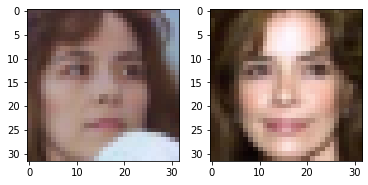

In [6]:
# datapoint 1
fig = plt.figure()
ax1, ax2 = [fig.add_subplot(1,2,i+1) for i in range(2)]
ax1.imshow(X_train[6,:,:,0:3])
ax2.imshow(X_train[6,:,:,3:6])
plt.show()

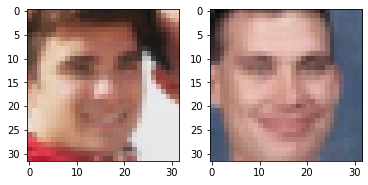

In [7]:
# datapoint 2
fig = plt.figure()
ax1, ax2 = [fig.add_subplot(1,2,i+1) for i in range(2)]
ax1.imshow(X_test[12,:,:,0:3])
ax2.imshow(X_test[12,:,:,3:6])
plt.show()

In [8]:
print(y_train.shape)
print("Zeros: %d"%(np.sum(y_train==0)))
print("Ones: %d"%(np.sum(y_train==1)))

(2200, 1)
Zeros: 1100
Ones: 1100


## Build Baseline Model

* Input
* Conv1: 32 feature, 3*3 kernel size
* Conv2: 64 feature, 3*3 kernel size
* Pooling1: 2*2
* Dropout1: 0.2
* FullConnect
* Dropout2: 0.5
* Output

In [9]:
# Baseline Model

base_model = Sequential()

# Input and first convolutional layer
base_model.add(Conv2D(32, (3,3),
                  input_shape=(ds,ds,6),
                  padding='same',
                  data_format='channels_last',
                  activation='relu'))

# Second convolutional layer
base_model.add(Conv2D(64, (3,3),
                  padding='same', 
                  data_format='channels_last',
                  activation='relu'))

# Pooling layer 1
base_model.add(AveragePooling2D(pool_size=(2,2),
                            data_format='channels_last'))

# Dropout after pooling 1
base_model.add(Dropout(0.2))

# Flatten layer.
base_model.add(Flatten())

# Fully connected layer
base_model.add(Dense(128, activation='relu',kernel_constraint=MaxNorm(3)))

# Dropout set to 50%.
base_model.add(Dropout(0.5))

# Output layer with 2 units (Y/N) (sigmoid activation function)
base_model.add(Dense(1, activation='sigmoid'))

print(base_model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1760      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
average_pooling2d (AveragePo (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
____

In [10]:
# Compile model:
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
epochs = 25
batch_size = 128

base_CNN = base_model.fit(X_train, y_train, 
           batch_size=batch_size, 
           epochs=epochs, 
           verbose=1,
           validation_data=(X_test, y_test))

Train on 2200 samples, validate on 1000 samples
Epoch 1/25
2200/2200 [==============================] - 6s 3ms/sample - loss: 0.7164 - binary_accuracy: 0.5086 - val_loss: 0.6863 - val_binary_accuracy: 0.5720
Epoch 2/25
2200/2200 [==============================] - 5s 2ms/sample - loss: 0.6756 - binary_accuracy: 0.5818 - val_loss: 0.6515 - val_binary_accuracy: 0.6570
Epoch 3/25
2200/2200 [==============================] - 5s 2ms/sample - loss: 0.6496 - binary_accuracy: 0.6305 - val_loss: 0.6285 - val_binary_accuracy: 0.6490
Epoch 4/25
2200/2200 [==============================] - 5s 2ms/sample - loss: 0.6296 - binary_accuracy: 0.6518 - val_loss: 0.6138 - val_binary_accuracy: 0.6830
Epoch 5/25
2200/2200 [==============================] - 5s 2ms/sample - loss: 0.6059 - binary_accuracy: 0.6936 - val_loss: 0.6004 - val_binary_accuracy: 0.6900
Epoch 6/25
2200/2200 [==============================] - 5s 2ms/sample - loss: 0.5991 - binary_accuracy: 0.6941 - val_loss: 0.5978 - val_binary_accuracy:

In [12]:
res1 = base_model.predict(X_train)
res2 = base_model.predict(X_test)

In [13]:
print("Training Data:")
print("Zeros: %d"%(np.sum(res1<0.5)))
print("Ones: %d"%(np.sum(res1>0.5)))
print("\n")
print("Testing Data:")
print("Zeros: %d"%(np.sum(res2<0.5)))
print("Ones: %d"%(np.sum(res2>0.5)))

Training Data:
Zeros: 1116
Ones: 1084


Testing Data:
Zeros: 527
Ones: 473


In [14]:
score = base_model.evaluate(X_test, y_test, verbose=0)
print('Baseline Test accuracy: {0:%}'.format(score[1]))

Baseline Test accuracy: 70.300001%


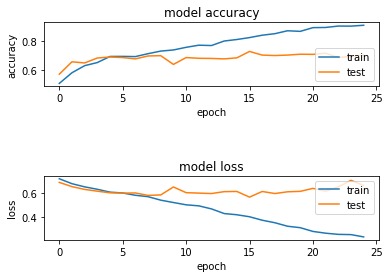

In [15]:
plt.subplot(3,1,1)
plt.plot(base_CNN.history['binary_accuracy'])
plt.plot(base_CNN.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(3,1,3)
plt.plot(base_CNN.history['loss'])
plt.plot(base_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

## Model A
kernel size: 5*5

In [16]:
modelA = Sequential()

# Input and first convolutional layer
modelA.add(Conv2D(32, (5,5),
                  input_shape=(ds,ds,6),
                  padding='same',
                  data_format='channels_last',
                  activation='relu'))

# Second convolutional layer
modelA.add(Conv2D(64, (5,5),
                  padding='same', 
                  data_format='channels_last',
                  activation='relu'))

# Pooling layer 1
modelA.add(AveragePooling2D(pool_size=(2,2),
                            data_format='channels_last'))

# Dropout after pooling 1
modelA.add(Dropout(0.2))

# Flatten layer.
modelA.add(Flatten())

# Fully connected layer
modelA.add(Dense(128, activation='relu',kernel_constraint=MaxNorm(3)))

# Dropout set to 50%.
modelA.add(Dropout(0.5))

# Output layer with 2 units (Y/N) (sigmoid activation function)
modelA.add(Dense(1, activation='sigmoid'))

print(modelA.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4832      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [17]:
# Compile model:
modelA.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [18]:
epochs = 25
batch_size = 128

modelA_CNN = modelA.fit(X_train, y_train, 
           batch_size=batch_size, 
           epochs=epochs, 
           verbose=1,
           validation_data=(X_test, y_test))

Train on 2200 samples, validate on 1000 samples
Epoch 1/25
2200/2200 [==============================] - 9s 4ms/sample - loss: 0.7250 - binary_accuracy: 0.5159 - val_loss: 0.6944 - val_binary_accuracy: 0.5000
Epoch 2/25
2200/2200 [==============================] - 8s 4ms/sample - loss: 0.6946 - binary_accuracy: 0.5036 - val_loss: 0.6929 - val_binary_accuracy: 0.5430
Epoch 3/25
2200/2200 [==============================] - 8s 4ms/sample - loss: 0.6933 - binary_accuracy: 0.5050 - val_loss: 0.6907 - val_binary_accuracy: 0.5030
Epoch 4/25
2200/2200 [==============================] - 8s 4ms/sample - loss: 0.6866 - binary_accuracy: 0.5291 - val_loss: 0.6830 - val_binary_accuracy: 0.5660
Epoch 5/25
2200/2200 [==============================] - 8s 4ms/sample - loss: 0.6746 - binary_accuracy: 0.5768 - val_loss: 0.6719 - val_binary_accuracy: 0.5820
Epoch 6/25
2200/2200 [==============================] - 8s 4ms/sample - loss: 0.6715 - binary_accuracy: 0.5818 - val_loss: 0.6725 - val_binary_accuracy:

In [19]:
res1 = modelA.predict(X_train)
res2 = modelA.predict(X_test)

In [20]:
print("Training Data:")
print("Zeros: %d"%(np.sum(res1<0.5)))
print("Ones: %d"%(np.sum(res1>0.5)))
print("\n")
print("Testing Data:")
print("Zeros: %d"%(np.sum(res2<0.5)))
print("Ones: %d"%(np.sum(res2>0.5)))

Training Data:
Zeros: 1095
Ones: 1105


Testing Data:
Zeros: 534
Ones: 466


In [21]:
score = modelA.evaluate(X_test, y_test, verbose=0)
print('modelA Test accuracy: {0:%}'.format(score[1]))

modelA Test accuracy: 69.999999%


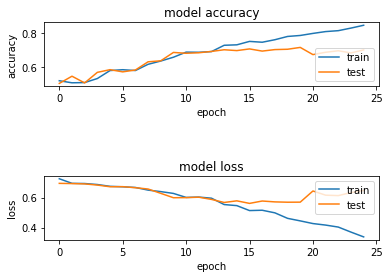

In [22]:
plt.subplot(3,1,1)
plt.plot(modelA_CNN.history['binary_accuracy'])
plt.plot(modelA_CNN.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(3,1,3)
plt.plot(modelA_CNN.history['loss'])
plt.plot(modelA_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

## Model B
kernel size: 7*7

In [23]:
modelB = Sequential()

# Input and first convolutional layer
modelB.add(Conv2D(32, (7,7),
                  input_shape=(ds,ds,6),
                  padding='same',
                  data_format='channels_last',
                  activation='relu'))

# Second convolutional layer
modelB.add(Conv2D(64, (7,7),
                  padding='same', 
                  data_format='channels_last',
                  activation='relu'))

# Pooling layer 1
modelB.add(AveragePooling2D(pool_size=(2,2),
                            data_format='channels_last'))

# Dropout after pooling 1
modelB.add(Dropout(0.2))

# Flatten layer.
modelB.add(Flatten())

# Fully connected layer
modelB.add(Dense(128, activation='relu',kernel_constraint=MaxNorm(3)))

# Dropout set to 50%.
modelB.add(Dropout(0.5))

# Output layer with 2 units (Y/N) (sigmoid activation function)
modelB.add(Dense(1, activation='sigmoid'))

print(modelB.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9440      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        100416    
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [24]:
# Compile model:
modelB.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [25]:
epochs = 25
batch_size = 128

modelB_CNN = modelB.fit(X_train, y_train, 
           batch_size=batch_size, 
           epochs=epochs, 
           verbose=1,
           validation_data=(X_test, y_test))

Train on 2200 samples, validate on 1000 samples
Epoch 1/25
2200/2200 [==============================] - 15s 7ms/sample - loss: 0.7179 - binary_accuracy: 0.4950 - val_loss: 0.6895 - val_binary_accuracy: 0.5620
Epoch 2/25
2200/2200 [==============================] - 14s 6ms/sample - loss: 0.6823 - binary_accuracy: 0.5505 - val_loss: 0.6764 - val_binary_accuracy: 0.5580
Epoch 3/25
2200/2200 [==============================] - 14s 6ms/sample - loss: 0.6852 - binary_accuracy: 0.5482 - val_loss: 0.7093 - val_binary_accuracy: 0.5360
Epoch 4/25
2200/2200 [==============================] - 14s 6ms/sample - loss: 0.6724 - binary_accuracy: 0.5895 - val_loss: 0.6439 - val_binary_accuracy: 0.6620
Epoch 5/25
2200/2200 [==============================] - 14s 6ms/sample - loss: 0.6588 - binary_accuracy: 0.6245 - val_loss: 0.6374 - val_binary_accuracy: 0.6670
Epoch 6/25
2200/2200 [==============================] - 14s 6ms/sample - loss: 0.6492 - binary_accuracy: 0.6259 - val_loss: 0.6187 - val_binary_acc

In [26]:
res1 = modelB.predict(X_train)
res2 = modelB.predict(X_test)

In [27]:
print("Training Data:")
print("Zeros: %d"%(np.sum(res1<0.5)))
print("Ones: %d"%(np.sum(res1>0.5)))
print("\n")
print("Testing Data:")
print("Zeros: %d"%(np.sum(res2<0.5)))
print("Ones: %d"%(np.sum(res2>0.5)))

Training Data:
Zeros: 1167
Ones: 1033


Testing Data:
Zeros: 598
Ones: 402


In [28]:
score = modelB.evaluate(X_test, y_test, verbose=0)
print('modelB Test accuracy: {0:%}'.format(score[1]))

modelB Test accuracy: 70.400000%


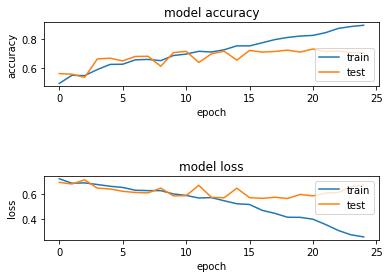

In [29]:
plt.subplot(3,1,1)
plt.plot(modelB_CNN.history['binary_accuracy'])
plt.plot(modelB_CNN.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(3,1,3)
plt.plot(modelB_CNN.history['loss'])
plt.plot(modelB_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

## Build More Complex Model

Compare baseline, modelA and modelB, we find that overall modelA is the best model(less underfitting).
So we build more complex model on top of modelA

Model C:
* Input
* Conv1: 32 feature, 5*5 kernel size
* Conv2: 64 feature, 5*5 kernel size
* Pooling1: 2*2
* Dropout1: 0.2
* Conv3: 128 feature, 5*5 kernel size
* Pooling2: 2*2
* Dropout2: 0.2
* FullConnect
* Dropout3: 0.5
* Output

In [30]:
# modelC

modelC = Sequential()

# Input and first convolutional layer
modelC.add(Conv2D(32, (5,5),
                  input_shape=(ds,ds,6),
                  padding='same',
                  data_format='channels_last',
                  activation='relu'))

# Second convolutional layer
modelC.add(Conv2D(64, (5,5),
                  padding='same', 
                  data_format='channels_last',
                  activation='relu'))

# Pooling layer 1
modelC.add(AveragePooling2D(pool_size=(2,2),
                            data_format='channels_last'))

# Dropout after pooling 1
modelC.add(Dropout(0.2))

# Third convolutional layer
modelC.add(Conv2D(128, (5,5),
                  padding='same', 
                  data_format='channels_last',
                  activation='relu'))

# Pooling layer 2
modelC.add(AveragePooling2D(pool_size=(2,2),
                            data_format='channels_last'))

# Dropout after pooling 2
modelC.add(Dropout(0.2))

# Flatten layer.
modelC.add(Flatten())

# Fully connected layer
modelC.add(Dense(128, activation='relu',kernel_constraint=MaxNorm(3)))

# Dropout set to 50%.
modelC.add(Dropout(0.5))

# Output layer with 2 units (Y/N) (sigmoid activation function)
modelC.add(Dense(1, activation='sigmoid'))

print(modelC.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        4832      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
average_pooling2d_3 (Average (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
average_pooling2d_4 (Average (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 128)        

In [31]:
# Compile model:
modelC.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [32]:
epochs = 25
batch_size = 128

modelC_CNN = modelC.fit(X_train, y_train, 
           batch_size=batch_size, 
           epochs=epochs, 
           verbose=1,
           validation_data=(X_test, y_test))

Train on 2200 samples, validate on 1000 samples
Epoch 1/25
2200/2200 [==============================] - 17s 8ms/sample - loss: 0.6990 - binary_accuracy: 0.4818 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 2/25
2200/2200 [==============================] - 16s 7ms/sample - loss: 0.6932 - binary_accuracy: 0.4977 - val_loss: 0.6928 - val_binary_accuracy: 0.5060
Epoch 3/25
2200/2200 [==============================] - 15s 7ms/sample - loss: 0.6894 - binary_accuracy: 0.5350 - val_loss: 0.6872 - val_binary_accuracy: 0.5400
Epoch 4/25
2200/2200 [==============================] - 15s 7ms/sample - loss: 0.6878 - binary_accuracy: 0.5500 - val_loss: 0.6687 - val_binary_accuracy: 0.6230
Epoch 5/25
2200/2200 [==============================] - 15s 7ms/sample - loss: 0.6643 - binary_accuracy: 0.5941 - val_loss: 0.6386 - val_binary_accuracy: 0.6390
Epoch 6/25
2200/2200 [==============================] - 15s 7ms/sample - loss: 0.6488 - binary_accuracy: 0.6336 - val_loss: 0.6237 - val_binary_acc

In [33]:
res1 = modelC.predict(X_train)
res2 = modelC.predict(X_test)

In [34]:
print("Training Data:")
print("Zeros: %d"%(np.sum(res1<0.5)))
print("Ones: %d"%(np.sum(res1>0.5)))
print("\n")
print("Testing Data:")
print("Zeros: %d"%(np.sum(res2<0.5)))
print("Ones: %d"%(np.sum(res2>0.5)))

Training Data:
Zeros: 1235
Ones: 965


Testing Data:
Zeros: 584
Ones: 416


In [35]:
score = modelC.evaluate(X_test, y_test, verbose=0)
print('modelC Test accuracy: {0:%}'.format(score[1]))

modelC Test accuracy: 69.999999%


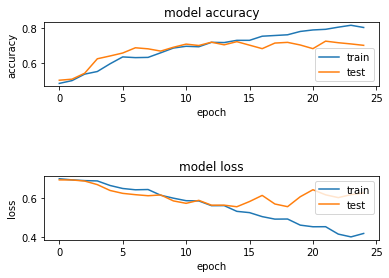

In [36]:
plt.subplot(3,1,1)
plt.plot(modelC_CNN.history['binary_accuracy'])
plt.plot(modelC_CNN.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(3,1,3)
plt.plot(modelC_CNN.history['loss'])
plt.plot(modelC_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

## Final Best Model

We experiment batch_size value: 32, 64, 128, 256
And we find, batch_size=128 is the best
So we use callback function to find the best model on top of modelC

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define a checkpoint to save the data
checkpoint_name = 'weights.best.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_binary_accuracy', verbose = 1, save_best_only = True, mode ='max')
callbacks_list = [checkpoint]

In [38]:
# Train the model
final_CNN = modelC.fit(X_train, y_train, 
           batch_size=128, 
           epochs=100, 
           verbose=1,
           validation_data=(X_test, y_test), 
           callbacks=callbacks_list)

Train on 2200 samples, validate on 1000 samples
Epoch 1/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.3833 - binary_accuracy: 0.8258
Epoch 00001: val_binary_accuracy improved from -inf to 0.69400, saving model to weights.best.hdf5
2200/2200 [==============================] - 15s 7ms/sample - loss: 0.3838 - binary_accuracy: 0.8250 - val_loss: 0.6055 - val_binary_accuracy: 0.6940
Epoch 2/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.3529 - binary_accuracy: 0.8415
Epoch 00002: val_binary_accuracy improved from 0.69400 to 0.71200, saving model to weights.best.hdf5
2200/2200 [==============================] - 15s 7ms/sample - loss: 0.3522 - binary_accuracy: 0.8418 - val_loss: 0.6078 - val_binary_accuracy: 0.7120
Epoch 3/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.3178 - binary_accuracy: 0.8566
Epoch 00003: val_binary_accuracy did not improve from 0.71200
2200/2200 [==============================] - 15s 7ms/sample - loss: 0.317

2176/2200 [============================>.] - ETA: 0s - loss: 0.0788 - binary_accuracy: 0.9697
Epoch 00026: val_binary_accuracy did not improve from 0.72100
2200/2200 [==============================] - 17s 8ms/sample - loss: 0.0792 - binary_accuracy: 0.9691 - val_loss: 1.1344 - val_binary_accuracy: 0.6980
Epoch 27/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.0829 - binary_accuracy: 0.9729
Epoch 00027: val_binary_accuracy did not improve from 0.72100
2200/2200 [==============================] - 17s 8ms/sample - loss: 0.0830 - binary_accuracy: 0.9727 - val_loss: 1.1183 - val_binary_accuracy: 0.6850
Epoch 28/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.0901 - binary_accuracy: 0.9688
Epoch 00028: val_binary_accuracy improved from 0.72100 to 0.72800, saving model to weights.best.hdf5
2200/2200 [==============================] - 18s 8ms/sample - loss: 0.0895 - binary_accuracy: 0.9691 - val_loss: 1.0455 - val_binary_accuracy: 0.7280
Epoch 29/100
2176

Epoch 52/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.0357 - binary_accuracy: 0.9876
Epoch 00052: val_binary_accuracy did not improve from 0.72800
2200/2200 [==============================] - 18s 8ms/sample - loss: 0.0356 - binary_accuracy: 0.9877 - val_loss: 1.2991 - val_binary_accuracy: 0.7050
Epoch 53/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.0269 - binary_accuracy: 0.9903
Epoch 00053: val_binary_accuracy did not improve from 0.72800
2200/2200 [==============================] - 18s 8ms/sample - loss: 0.0266 - binary_accuracy: 0.9905 - val_loss: 1.6198 - val_binary_accuracy: 0.6990
Epoch 54/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.0345 - binary_accuracy: 0.9881
Epoch 00054: val_binary_accuracy did not improve from 0.72800
2200/2200 [==============================] - 18s 8ms/sample - loss: 0.0354 - binary_accuracy: 0.9877 - val_loss: 1.4569 - val_binary_accuracy: 0.7050
Epoch 55/100
2176/2200 [===================

Epoch 78/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.0171 - binary_accuracy: 0.9949
Epoch 00078: val_binary_accuracy did not improve from 0.72800
2200/2200 [==============================] - 18s 8ms/sample - loss: 0.0169 - binary_accuracy: 0.9950 - val_loss: 1.6723 - val_binary_accuracy: 0.7030
Epoch 79/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.0150 - binary_accuracy: 0.9968
Epoch 00079: val_binary_accuracy did not improve from 0.72800
2200/2200 [==============================] - 17s 8ms/sample - loss: 0.0151 - binary_accuracy: 0.9968 - val_loss: 1.6951 - val_binary_accuracy: 0.7040
Epoch 80/100
2176/2200 [============================>.] - ETA: 0s - loss: 0.0106 - binary_accuracy: 0.9972
Epoch 00080: val_binary_accuracy did not improve from 0.72800
2200/2200 [==============================] - 17s 8ms/sample - loss: 0.0105 - binary_accuracy: 0.9973 - val_loss: 1.7259 - val_binary_accuracy: 0.7140
Epoch 81/100
2176/2200 [===================

In [39]:
# Load wights file of the best model :
wights_file = 'weights.best.hdf5'
best_CNN = modelC.load_weights(wights_file) # load it
modelC.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [40]:
score = modelC.evaluate(X_test, y_test, verbose=0)
print('Best CNN Model Test accuracy: {0:%}'.format(score[1]))

Best CNN Model Test accuracy: 72.799999%


In [41]:
# Make predictions
predictions = modelC.predict(X_test)

In [42]:
predictions

array([[3.36706936e-01],
       [6.15119934e-05],
       [9.56135035e-01],
       [2.48032808e-03],
       [1.13038272e-01],
       [9.98085678e-01],
       [3.25866759e-01],
       [9.54843640e-01],
       [1.00000000e+00],
       [8.95335317e-01],
       [3.47958922e-01],
       [2.16363668e-02],
       [1.44955635e-01],
       [9.99999881e-01],
       [2.69778967e-02],
       [7.69262195e-01],
       [9.07015562e-01],
       [9.99962389e-01],
       [5.96199572e-01],
       [9.99930978e-01],
       [9.40831184e-01],
       [3.20076942e-04],
       [2.43819654e-02],
       [1.33589834e-01],
       [9.79445338e-01],
       [9.93263245e-01],
       [9.85867977e-01],
       [6.51359558e-04],
       [9.98468757e-01],
       [9.99912262e-01],
       [7.82144845e-01],
       [7.73757696e-04],
       [2.79254317e-02],
       [9.29361224e-01],
       [9.65422034e-01],
       [9.99713898e-01],
       [1.36792660e-04],
       [1.79557204e-02],
       [1.08182430e-05],
       [2.34983742e-01],


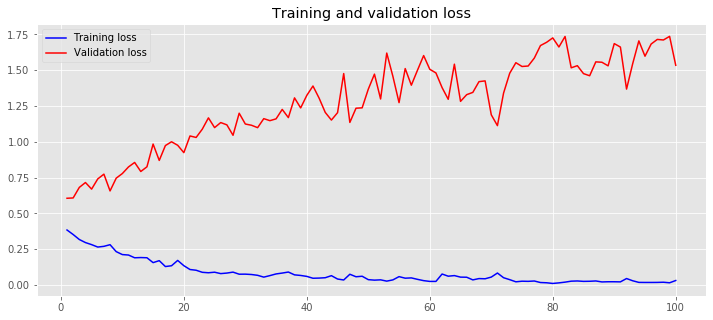

In [43]:
plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


plot_history(final_CNN)

## End